<a href="https://colab.research.google.com/github/serdarbozoglan/01_Computer_Vision/blob/master/Transfer_Learning_for_Image_Classification_Traffic_Sign_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial

https://www.youtube.com/watch?v=yYlVOrbV_KY

https://colab.research.google.com/drive/1Lk5R4pECDxDhd1uXcv26YRQ02fb_mrL9#scrollTo=K1OK2nyYf26t

In [1]:
!nvidia-smi

Thu Apr 30 01:50:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install -q -U watermark

In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,torchvision

CPython 3.6.9
IPython 5.5.0

numpy 1.18.3
pandas 1.0.3
torch 1.5.0+cu101
torchvision 0.6.0+cu101


In [4]:
import torch, torchvision

import os
import ntpath
import numpy as np
import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
import urllib
import json
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
from tqdm import tqdm
import time
import copy
import shutil
from collections import defaultdict
import albumentations as A

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 4299
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


device(type='cuda')

## Data

In [5]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

## unzip'teki --qq flag'i verbosity ' kapatir
!unzip -qq GTSRB_Final_Training_Images.zip

--2020-04-30 01:50:29--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M   169MB/s    in 1.6s    

2020-04-30 01:50:31 (169 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [0]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))

In [7]:
# num of classes/ trafic signs
len(train_folders)

43

## Exploration

In [0]:
def show_image(img_path):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')

In [0]:
def load_image(img_path, resize=True):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    if resize:
        img = cv2.resize(img, (64,64), interpolation=cv2.INTER_AREA)
    return img

In [0]:
def show_traffcsign_grid(image_paths):
    images = [load_image(img) for img in image_paths]
    # Open CV uses np array so we need to convert them to Tensors
    images = torch.as_tensor(images)

    # we will permute the color chnanels (permute sirasini degisitmek)
    # Daha once load_image icinde zaten RGB formatina gecmistik
    # burada (3) --> Blue, sonra (1) ---> Red ve (2) --> Green sirasini istiyoruz (BRG)
    images = images.permute(0, 3, 1, 2)
    
    # we want 11 images side by side
    grid_img = torchvision.utils.make_grid(images, nrow=11)
    plt.figure(figsize=(16,8))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

In [0]:
# image'lerin uzantilari ppm
# her bir class/folder'dan bir image sample_images'a atilmis olur
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]

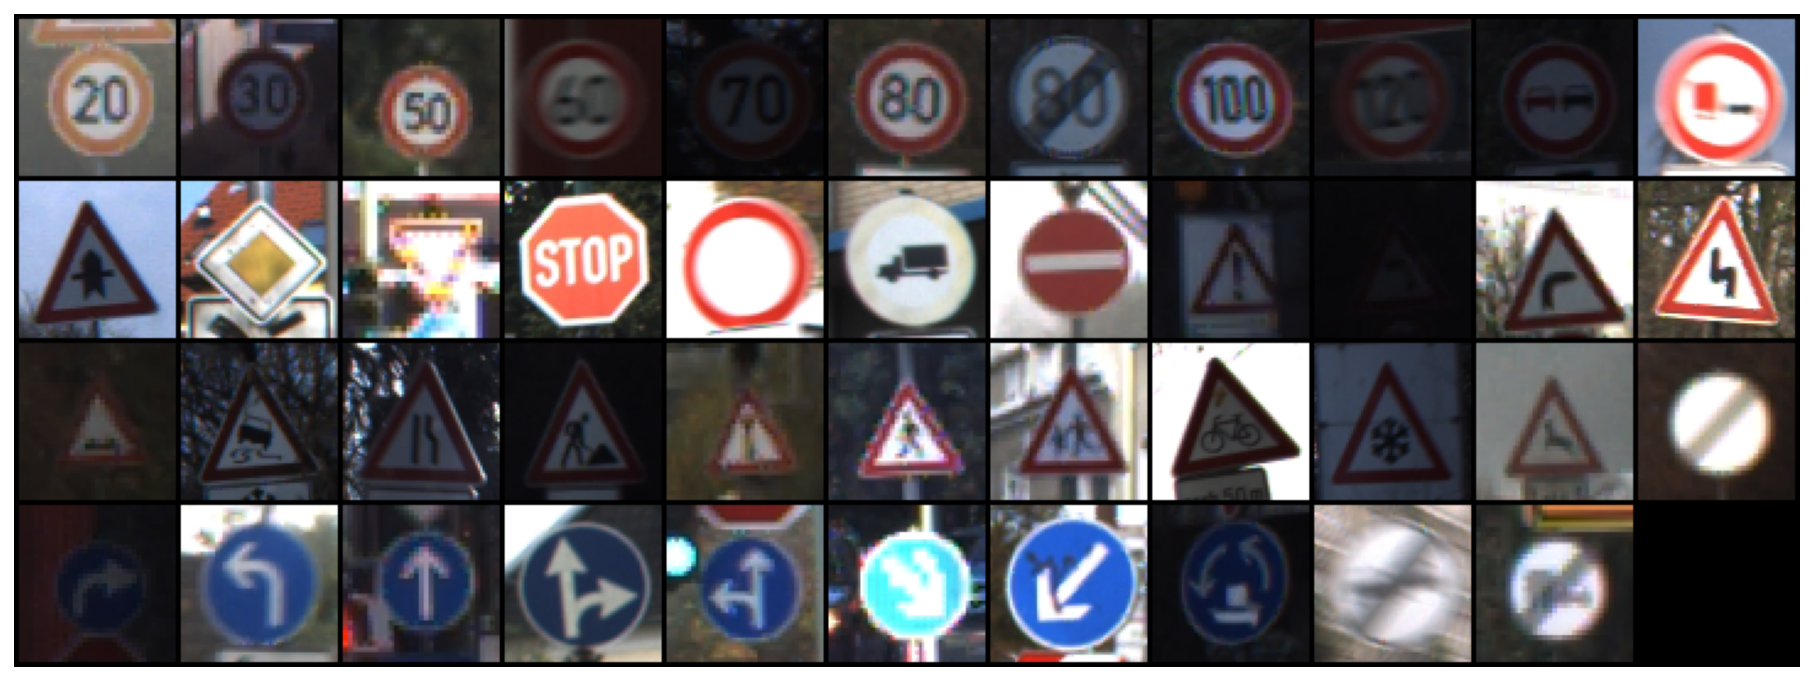

In [12]:
show_traffcsign_grid(sample_images)

In [0]:
path = 'GTSRB/Final_Training/Images/*'

In [14]:
for folder in glob(path):
    subfolder_name = folder.split('/')[-1]
    #print(subfolder_name)
    print("folder name :", subfolder_name, "&&", "# of examples :", len(os.listdir(folder)))
# Dataset is imbalanced

folder name : 00023 && # of examples : 511
folder name : 00022 && # of examples : 391
folder name : 00014 && # of examples : 781
folder name : 00028 && # of examples : 541
folder name : 00035 && # of examples : 1201
folder name : 00026 && # of examples : 601
folder name : 00016 && # of examples : 421
folder name : 00037 && # of examples : 211
folder name : 00001 && # of examples : 2221
folder name : 00011 && # of examples : 1321
folder name : 00041 && # of examples : 241
folder name : 00006 && # of examples : 421
folder name : 00009 && # of examples : 1471
folder name : 00008 && # of examples : 1411
folder name : 00033 && # of examples : 690
folder name : 00034 && # of examples : 421
folder name : 00005 && # of examples : 1861
folder name : 00030 && # of examples : 451
folder name : 00036 && # of examples : 391
folder name : 00018 && # of examples : 1201
folder name : 00025 && # of examples : 1501
folder name : 00042 && # of examples : 241
folder name : 00038 && # of examples : 2071
fo

In [0]:
# We'll only select 4 subsets of these images

In [16]:
for folder in glob(path):
    subfolder_name = folder.split('/')[-1]
    #print(subfolder_name)
    if subfolder_name in ['00012', '00013', '00014', '00017']:
        print("folder name :", subfolder_name, "&&", "# of examples :", len(os.listdir(folder)))

folder name : 00014 && # of examples : 781
folder name : 00013 && # of examples : 2161
folder name : 00012 && # of examples : 2101
folder name : 00017 && # of examples : 1111


In [0]:
# We'll augment folder name 14 and folder name 17 up to 2K

## Data Augmentation

In [0]:
doc_aug = A.Compose([
                     A.Flip(p=0.25),
                     A.RandomGamma(gamma_limit=(20,300)),
                     A.RandomBrightnessContrast(p=0.85),
                     A.Rotate(limit=0.35, p=0.9),
                     A.RandomRotate90(p=0.9),
                     A.RGBShift(p=0.75),
                     A.GaussNoise(p=0.25)])

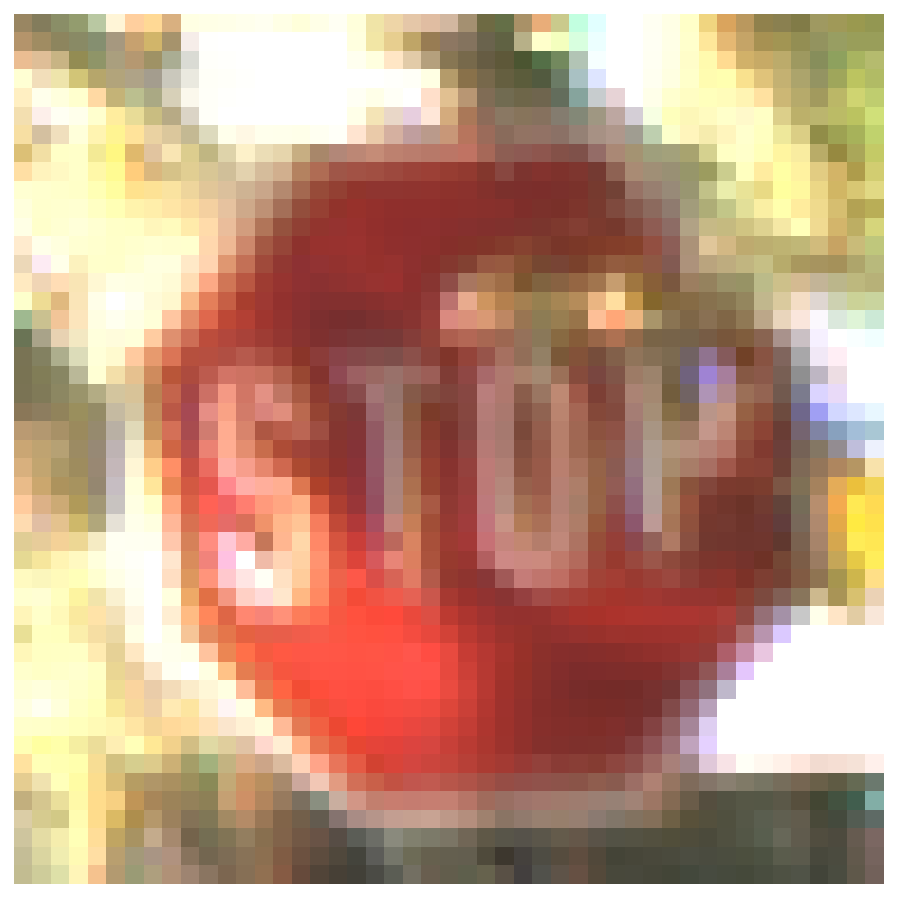

In [19]:
img_to_be_augmented = glob(f'{train_folders[14]}/*ppm')[33]
show_image(img_to_be_augmented)

In [0]:
img_to_be_augmented = cv2.cvtColor(cv2.imread(img_to_be_augmented), cv2.COLOR_BGR2RGB)

In [0]:
# Path for STOP Sign
Augmented_StopSign_Path = 'data/augmented/stopsign'  
os.makedirs(Augmented_StopSign_Path, exist_ok=True)

In [22]:
for i in tqdm(range(1350)):
    augmented = doc_aug(image=img_to_be_augmented)
    file_name = f'stop_sign_aug_{i}.ppm'
    cv2.imwrite(f'{Augmented_StopSign_Path}/{file_name}', augmented['image'])

100%|██████████| 1350/1350 [00:01<00:00, 1185.40it/s]


### 2nd Augmenattion for Folder Num 17 (No ENTRY)

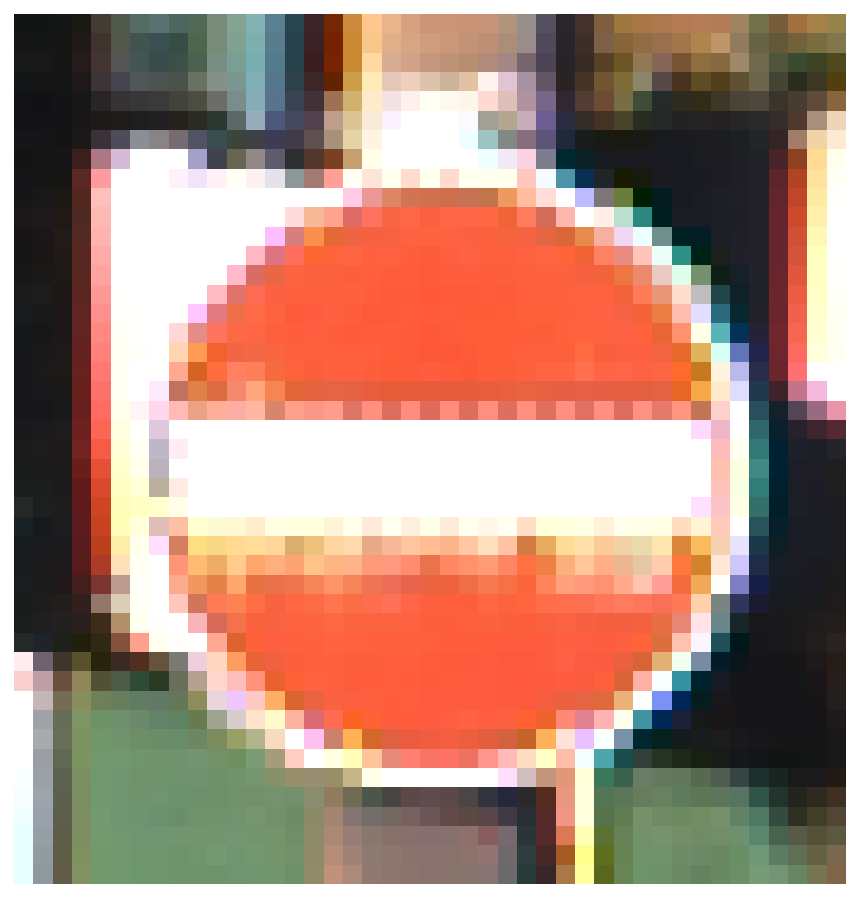

In [23]:
img_to_be_augmented = glob(f'{train_folders[17]}/*ppm')[22]
show_image(img_to_be_augmented)

In [0]:
img_to_be_augmented = cv2.cvtColor(cv2.imread(img_to_be_augmented), cv2.COLOR_BGR2RGB)

In [0]:
# Path for No_ENTRY Sign
Augmented_NoEntry_Path = 'data/augmented/noentry'  
os.makedirs(Augmented_NoEntry_Path, exist_ok=True)

In [26]:
for i in tqdm(range(1000)):
    augmented = doc_aug(image=img_to_be_augmented)
    file_name = f'noentry_sign_aug_{i}.ppm'
    cv2.imwrite(f'{Augmented_NoEntry_Path}/{file_name}', augmented['image'])

100%|██████████| 1000/1000 [00:00<00:00, 1248.65it/s]


### Simdi Augment edilmis bu imagelari Orjinal KLasorlere Tasiyacagiz

In [0]:
!cp -a 'data/augmented/noentry/.' 'GTSRB/Final_Training/Images/00017'

In [0]:
!cp -a 'data/augmented/stopsign/.' 'GTSRB/Final_Training/Images/00014'

## Building Dataset

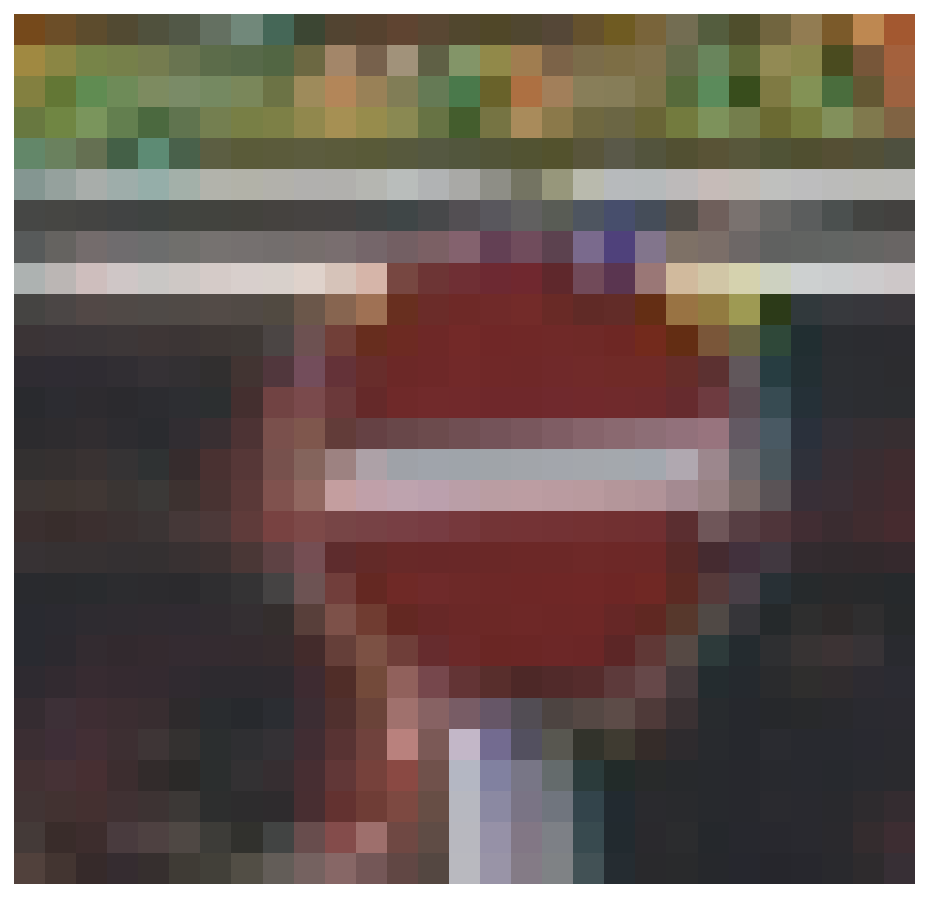

In [29]:
img_path = glob(f'{train_folders[17]}/*ppm')[1]
show_image(img_path)

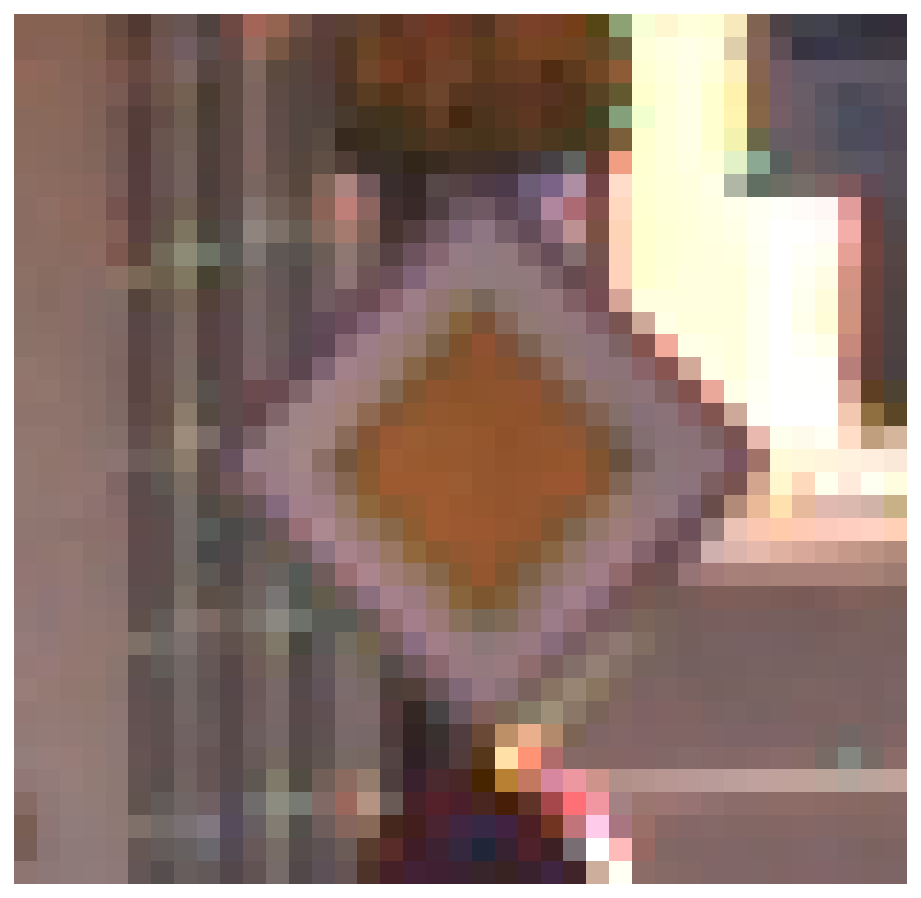

In [30]:
img_path = glob(f'{train_folders[12]}/*ppm')[3]
show_image(img_path)

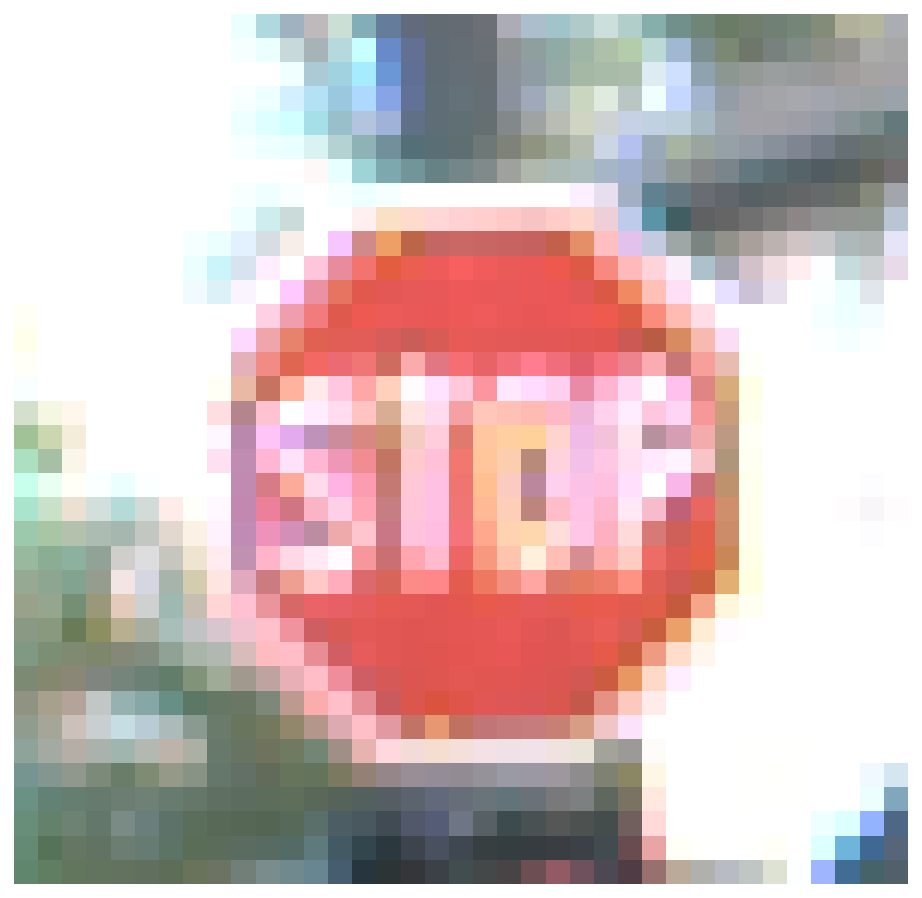

In [31]:
# augmented stopsign
img_path = glob(f'{train_folders[14]}/*ppm')[2000]
show_image(img_path)

In [0]:
class_names = ['priority_road', 'give_way', 'stop', 'no_entry']
class_indices =[12, 13, 14, 17]

In [0]:
os.makedirs('data/train', exist_ok=True)
os.makedirs('data/valid', exist_ok=True)
os.makedirs('data/test', exist_ok=True)

In [0]:
for cls in class_names:
    os.makedirs(f'data/train/{cls}', exist_ok=True)
    os.makedirs(f'data/valid/{cls}', exist_ok=True)
    os.makedirs(f'data/test/{cls}', exist_ok=True)

In [35]:
for i, cls_index in enumerate(class_indices):
    image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
    class_name = class_names[i]
    print(f'{class_name}: {len(image_paths)}')
    np.random.shuffle(image_paths)

    train, val, test = np.split(
                    image_paths, 
                    # here 0.8 is assigned for train, 0.9-0.8=0.1 is assigned for val and rest (0.1) is for test 
                    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))])
    for ip in train:
        shutil.copy(ip, f'data/train/{class_name}')
    for ip in val:
        shutil.copy(ip, f'data/valid/{class_name}')
    for ip in test:
      shutil.copy(ip, f'data/test/{class_name}')


priority_road: 2100
give_way: 2160
stop: 2130
no_entry: 2110


## Creating Transformations

In [0]:
# These values are recommended ResNet
# Size 256 is also reuired by ResNet

mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

chose_transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  # upto now those expects images now we need to convert into tensors
  T.ToTensor(),
  # Normalization is expected by pretrained model
  T.Normalize(mean_nums, std_nums)
]), 'valid': T.Compose([
  T.Resize(256),
  T.CenterCrop(224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(256),
  T.CenterCrop(224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

## Build Datasets

In [0]:
data_dir = 'data/'

chose_datasets = {
    x: ImageFolder(os.path.join(data_dir, x), transform=chose_transforms[x])
    for x in ['train', 'valid', 'test']
}

In [0]:
dataloaders = {x:DataLoader(dataset = chose_datasets[x], 
                            batch_size=16,
                            shuffle=True,
                            num_workers=4)
                for x in ['train', 'valid', 'test']}

In [39]:
device

device(type='cuda')

In [40]:
dataset_sizes = {x:len(chose_datasets[x]) for x in ['train', 'valid', 'test']}
dataset_sizes

{'test': 850, 'train': 6800, 'valid': 850}

In [41]:
class_names = chose_datasets['train'].classes
class_names

['give_way', 'no_entry', 'priority_road', 'stop']

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # mean_nums ve std_nums yukarida tanimlandi list olarak
    mean =  np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

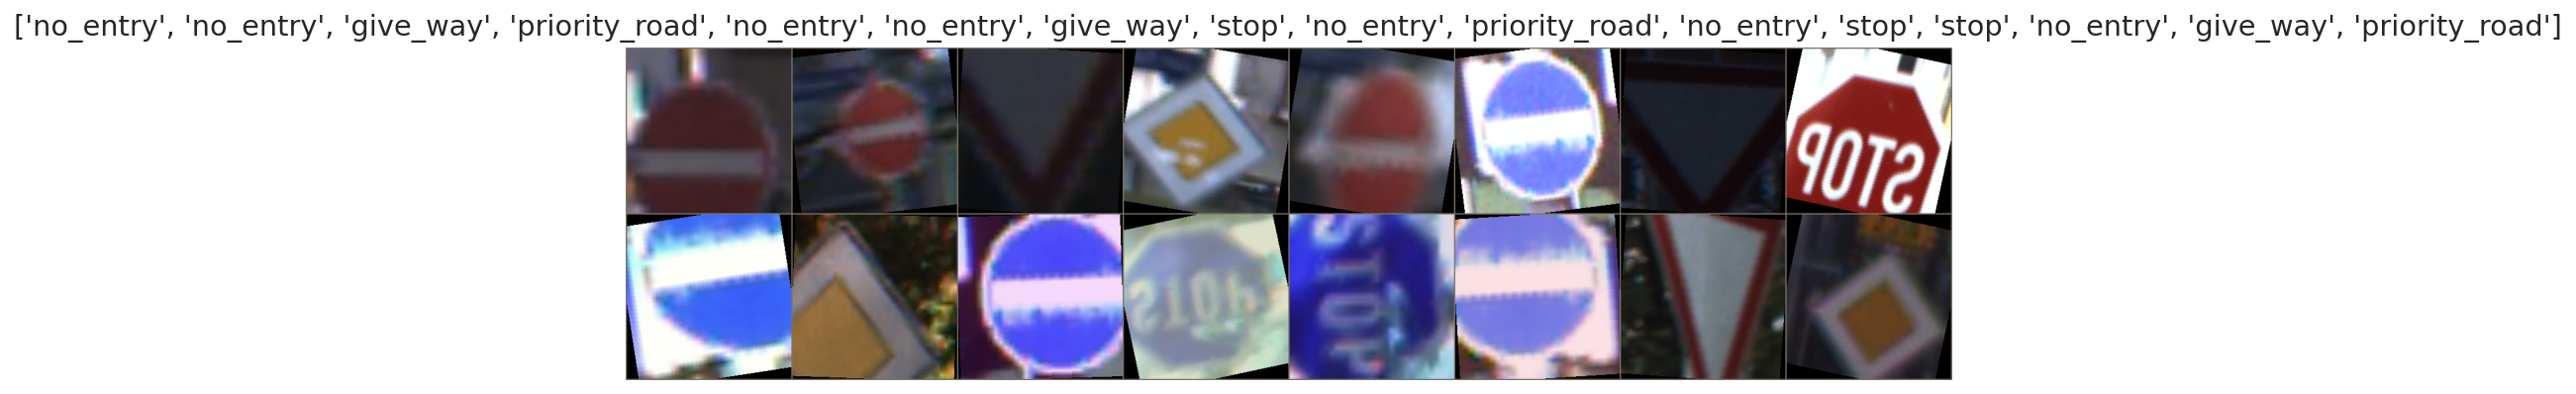

In [43]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Using ResNet Pretrained Model

In [0]:
def create_model(n_classes):
    model = models.resnet34(pretrained=True)

    n_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(n_features, n_classes),
        nn.Softmax(dim=1)
    )
    return model.to(device)

In [45]:
base_model = create_model(len(class_names))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


## Training Model

In [0]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples):

    model = model.train()

    losses = []
    correct_predictions = 0

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels= labels.to(device)

        outputs = model(inputs)

        _, preds = torch.max(outputs, dim=1) # o satirdaki en buyuk degeri prediction olarak aliyoruz, yani predicted classi buluyoruz
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds==labels)
        losses.append(loss.item())

        # ALTTAKI UPDATE'LER SADECE TRAIN PHASEDE
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    scheduler.step()

    return correct_predictions.double() / n_examples, np.mean(losses)


In [0]:
def evaluate_model(
    model,
    data_loader,
    loss_fn,
    device,
    n_examples):

    model = model.eval()
    
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in data_loader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, dim=1)
            
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [0]:
def train_model(
    model,
    dataloaders,
    dataset_sizes,
    device,
    n_epochs=3):

    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    loss_fn = nn.CrossEntropyLoss().to(device)

    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(n_epochs):
        print(f'Epoch {epoch +1}/{n_epochs}')
        print('-' * 33)

        train_acc, train_loss = train_epoch(
                                model,
                                dataloaders['train'],
                                loss_fn,
                                optimizer,
                                device,
                                scheduler,
                                dataset_sizes['train'])
        
        print(f'[INFO] Train Loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = evaluate_model(
            model,
            dataloaders['valid'],
            loss_fn,
            device,
            dataset_sizes['valid'])
        
        print(f'[INFO] Validation Loss {val_loss} accuracy {val_acc}')

        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc
        
    print(f'[INFO] Best Val Acc : {best_accuracy}' )

    model.load_state_dict(torch.load('best_model_state.bin'))

    return model, history

In [0]:
def get_predictions(model, data_loader):

    model = model.eval()
    predictions = []
    real_values = [] 

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()

    return predictions, real_values

In [0]:
def show_predictions(model, class_names, n_images=6):

    model = model.eval()
    images_handled = 0
    plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, dim=1)

            for j in range(inputs.shape[0]):
                images_handled += 1 
                ax = plt.subplot(2, n_images//2, images_handled)
                ax.set_title(f'predicted :  {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                ax.axis('off')

                if images_handled == n_images:
                    return

In [100]:
%%time
base_model, history = train_model(base_model, dataloaders, dataset_sizes, device)

Epoch 1/3
---------------------------------
[INFO] Train Loss 0.7633386252908145 accuracy 0.982205882352941
[INFO] Validation Loss 0.7449643810590109 accuracy 0.9988235294117647
Epoch 2/3
---------------------------------
[INFO] Train Loss 0.761458083040574 accuracy 0.9851470588235294
[INFO] Validation Loss 0.7447316315439012 accuracy 0.9988235294117647
Epoch 3/3
---------------------------------
[INFO] Train Loss 0.7590683193767772 accuracy 0.9874999999999999
[INFO] Validation Loss 0.7448176951320084 accuracy 0.9988235294117647
[INFO] Best Val Acc : 0
CPU times: user 1min 2s, sys: 18.3 s, total: 1min 20s
Wall time: 1min 27s


In [0]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    ax1.plot(history['train_loss'], label='train loss')
    ax1.plot(history['val_loss'], label='validation loss')

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend()
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    ax2.plot(history['train_acc'], label='train accuracy')
    ax2.plot(history['val_acc'], label='validation accuracy')

    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylim([-0.05, 1.05])
    ax2.legend()

    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')

    fig.suptitle('Training history')

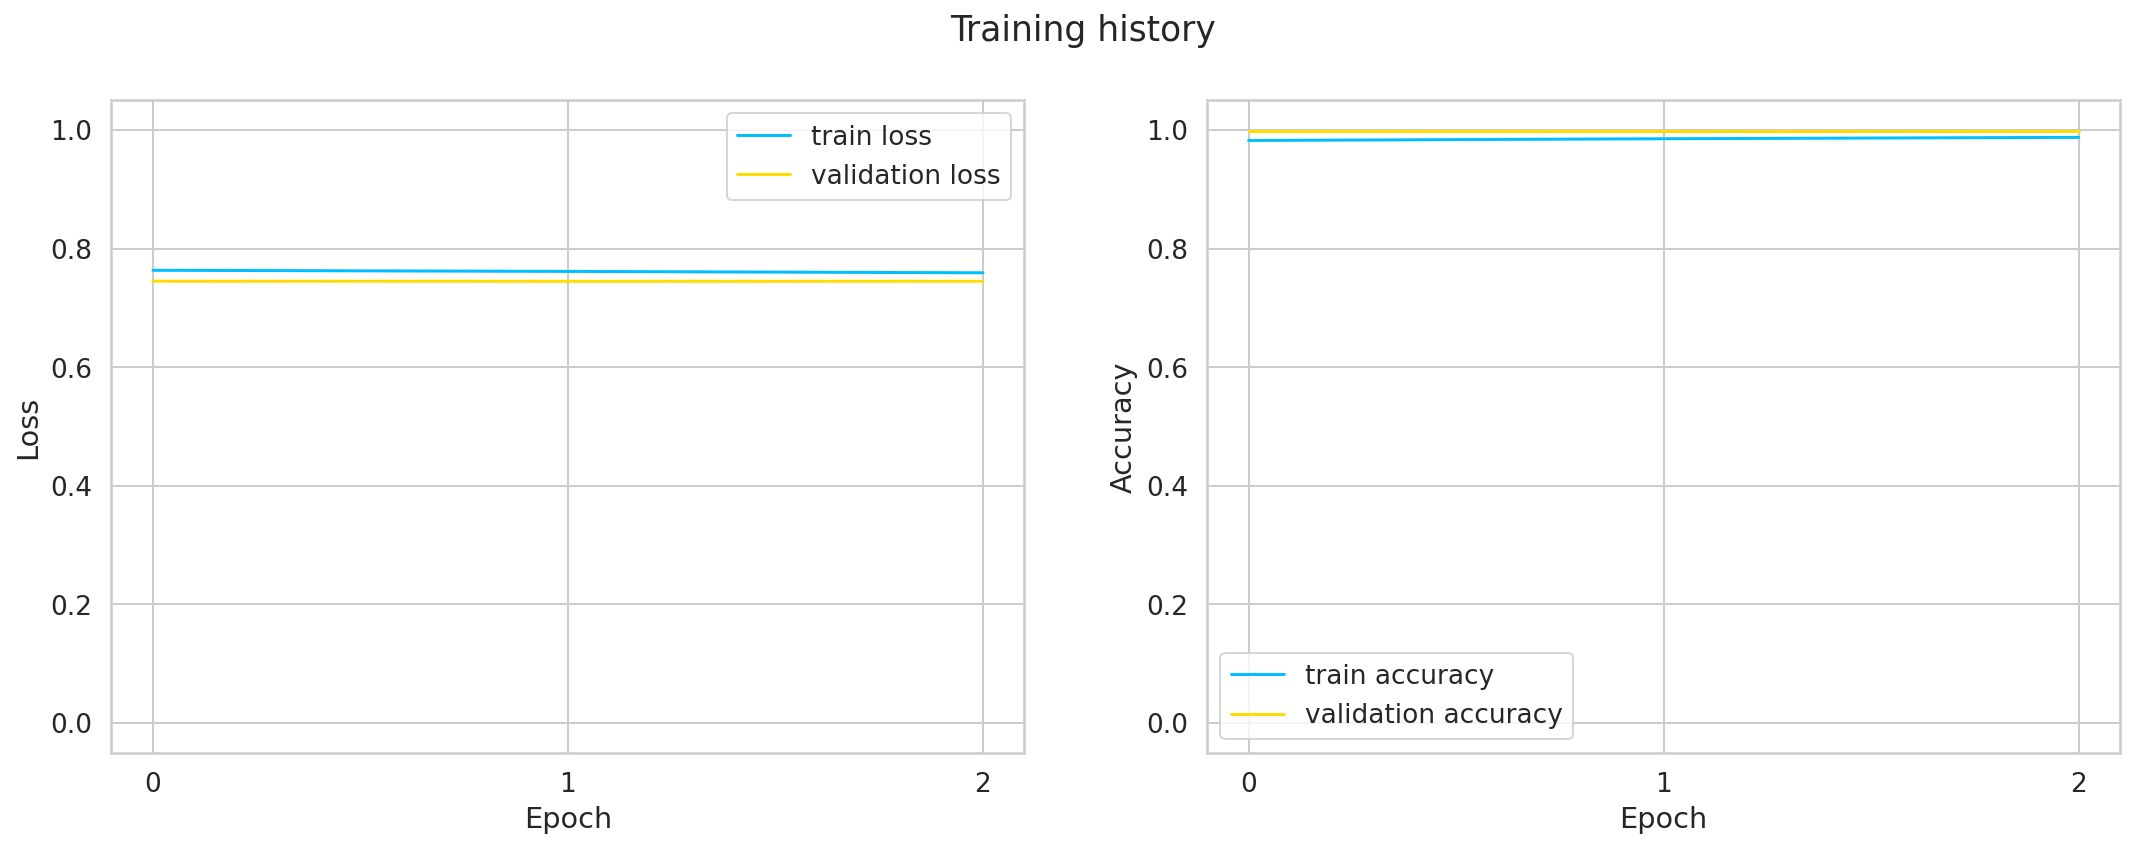

In [104]:
plot_training_history(history)

## Evaluation

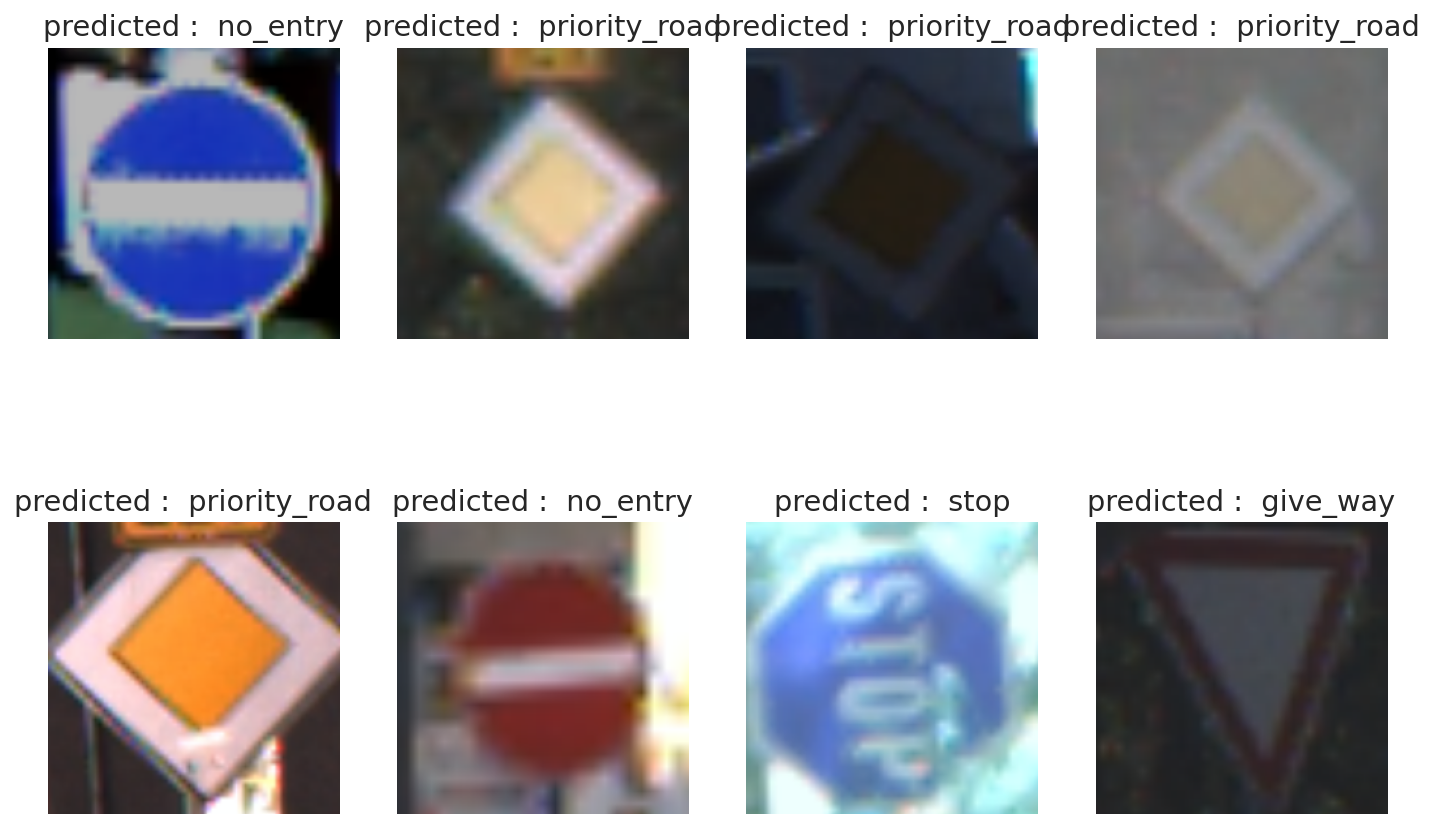

In [109]:
show_predictions(base_model, class_names, n_images=8)

In [0]:
y_pred, y_test = get_predictions(base_model, dataloaders['test'])

In [117]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

     give_way       1.00      1.00      1.00       216
     no_entry       1.00      1.00      1.00       211
priority_road       1.00      1.00      1.00       210
         stop       1.00      1.00      1.00       213

     accuracy                           1.00       850
    macro avg       1.00      1.00      1.00       850
 weighted avg       1.00      1.00      1.00       850



In [0]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

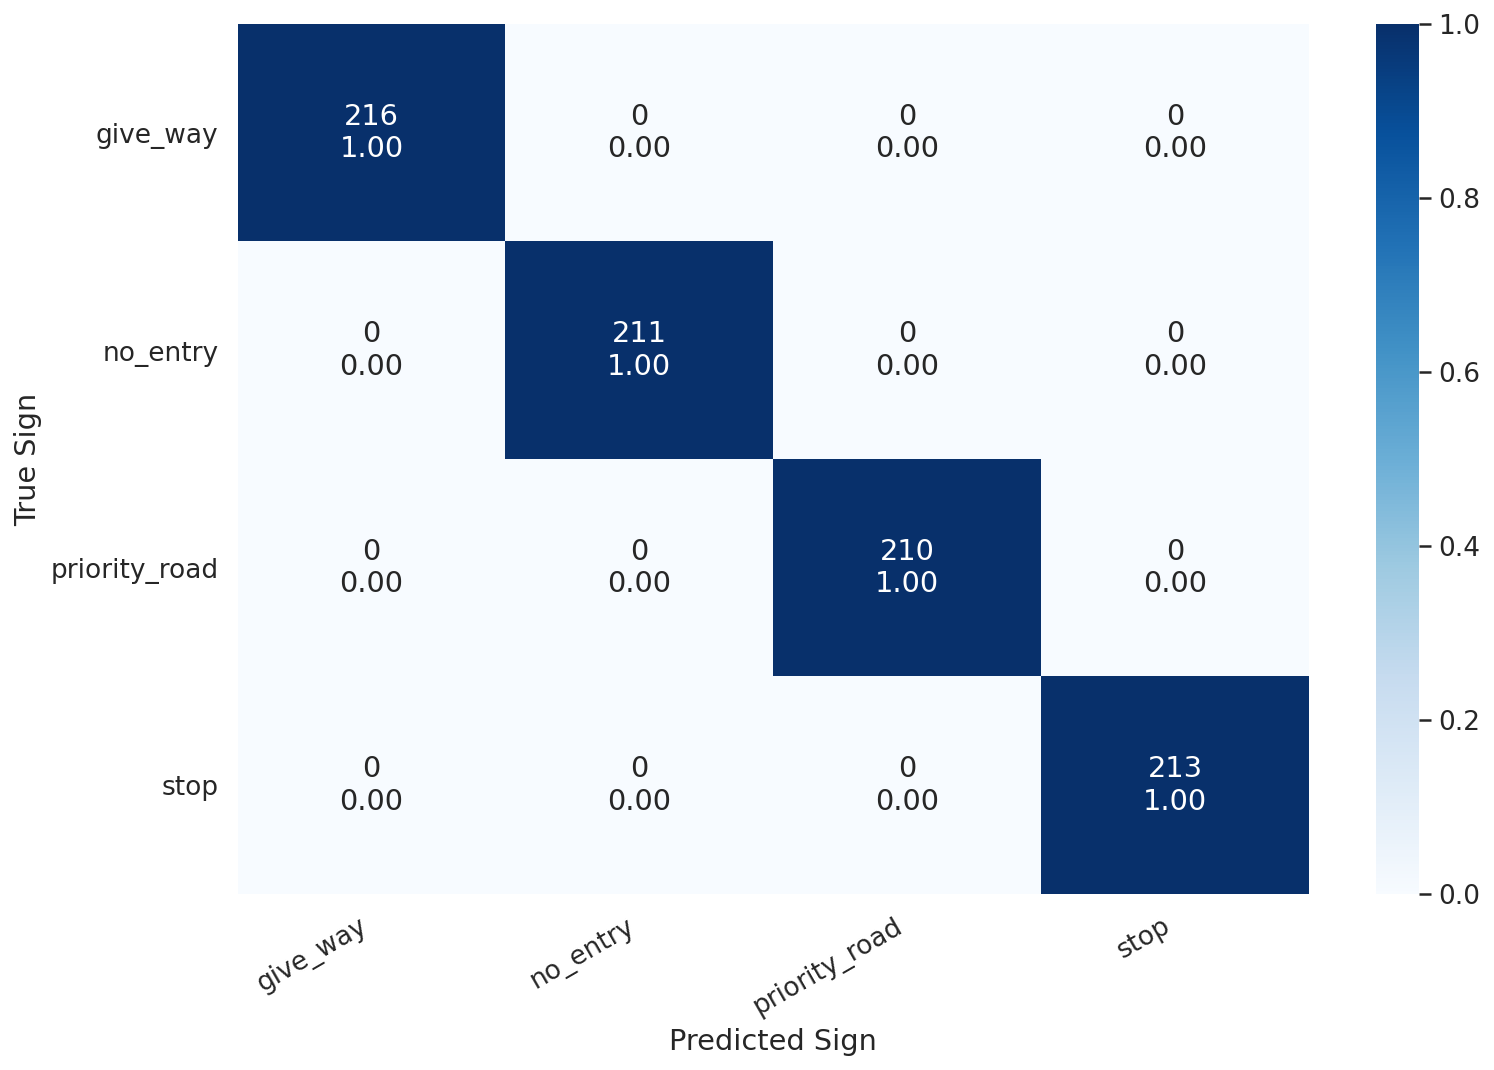

In [120]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

## Predicting

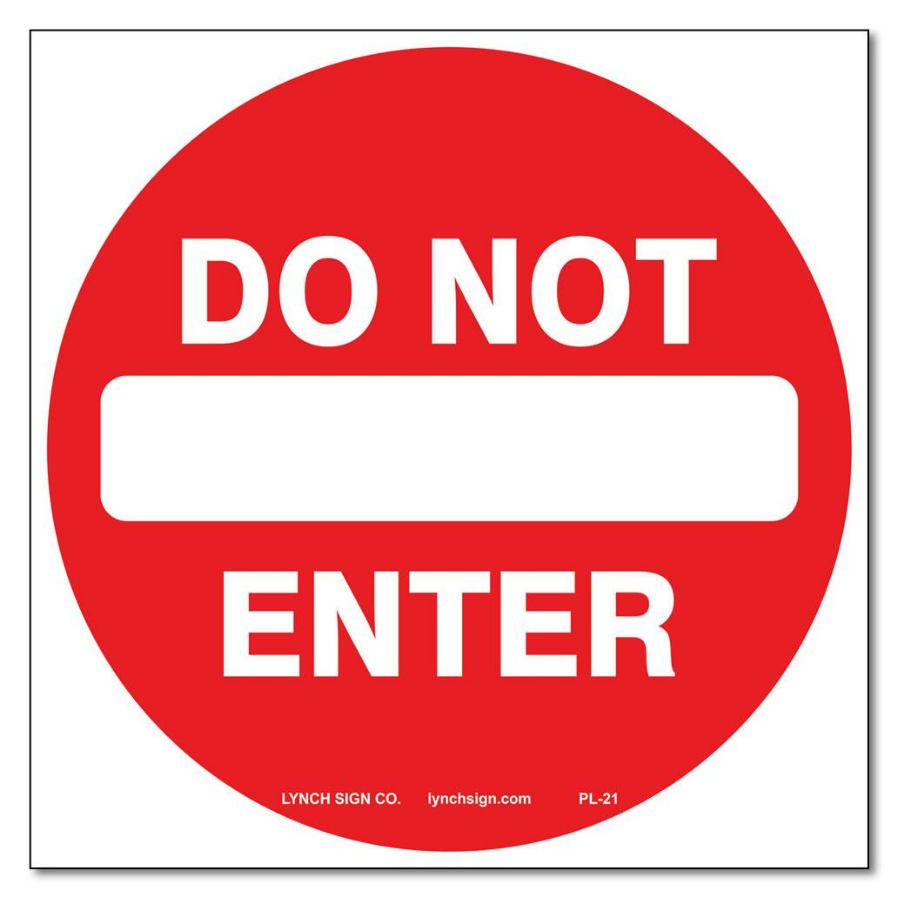

In [121]:
# Trainig Setteki Girilmez Levhalarinda 'Do NOT Enter' yazmamasina ragmen cok iyi tahmin:)  

show_image('do_not_enter.jpg')

In [0]:
def predict_proba(model, image_path):
    img = Image.open(image_path)
    img = img.convert('RGB')
    img = chose_transforms['test'](img).unsqueeze(0)

    pred = model(img.to(device))
    pred = F.softmax(pred, dim=1)

    return pred.detach().cpu().numpy().flatten()

In [131]:
pred = predict_proba(base_model, 'do_not_enter.jpg')
pred

array([0.17654315, 0.46812877, 0.1764819 , 0.17884621], dtype=float32)

In [132]:
class_names

['give_way', 'no_entry', 'priority_road', 'stop']

In [0]:
def show_prediction_confidence(prediction, class_names):
    pred_df = pd.DataFrame({'class_names': class_names,
                            'values' : prediction})
    sns.barplot(x='values', y='class_names', data=pred_df)

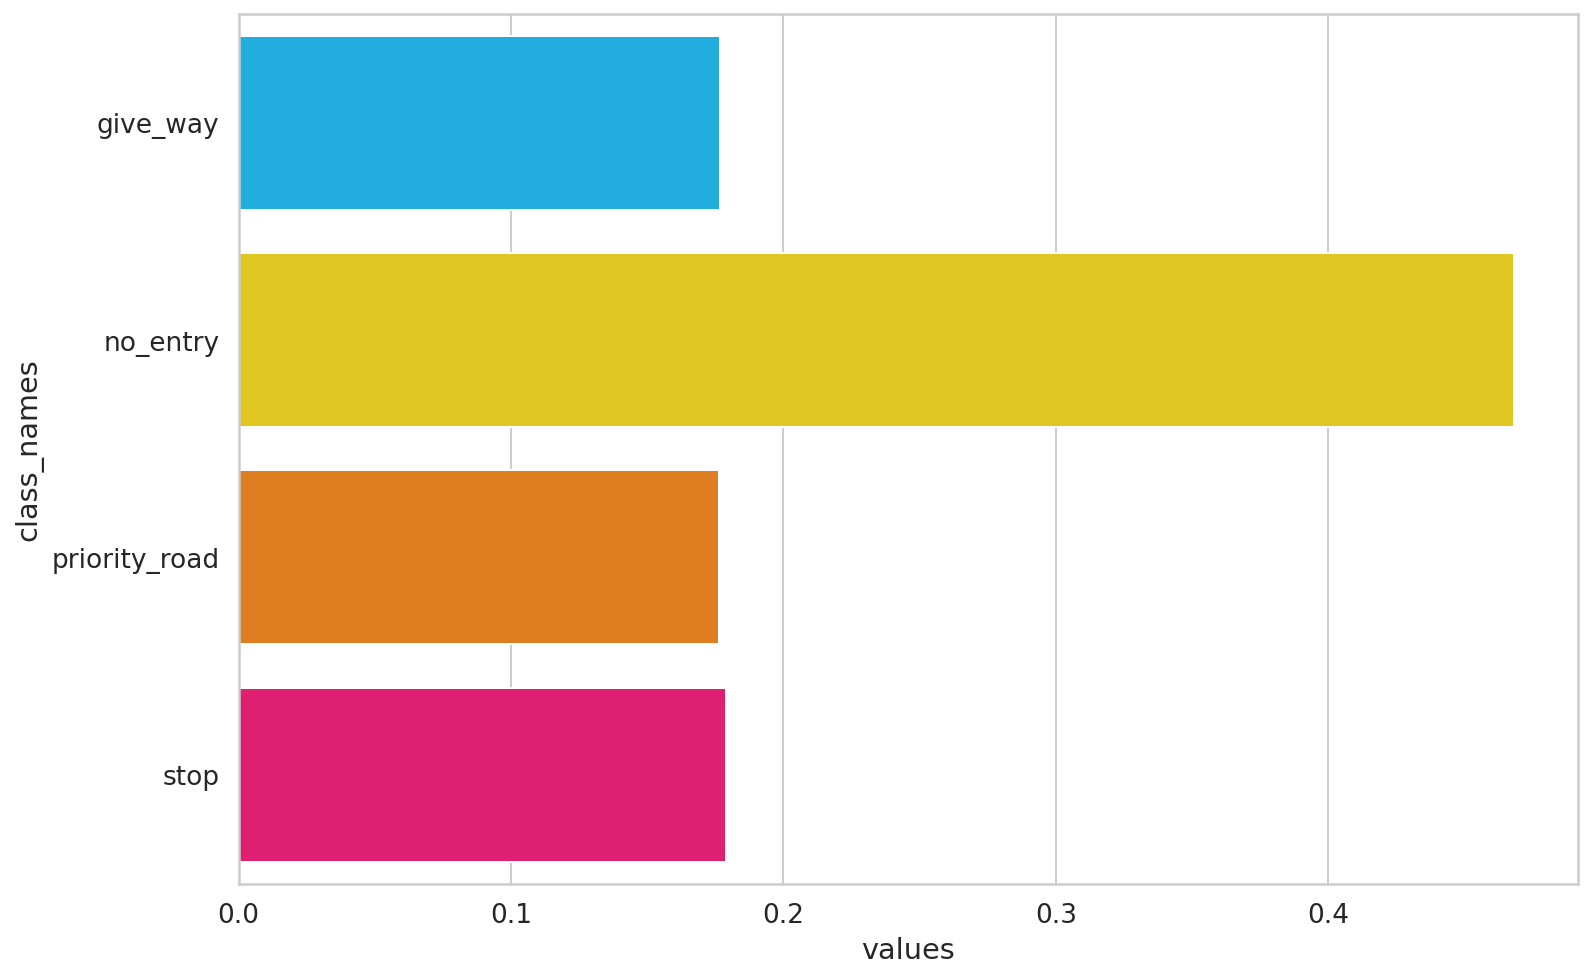

In [135]:
show_prediction_confidence(pred, class_names)

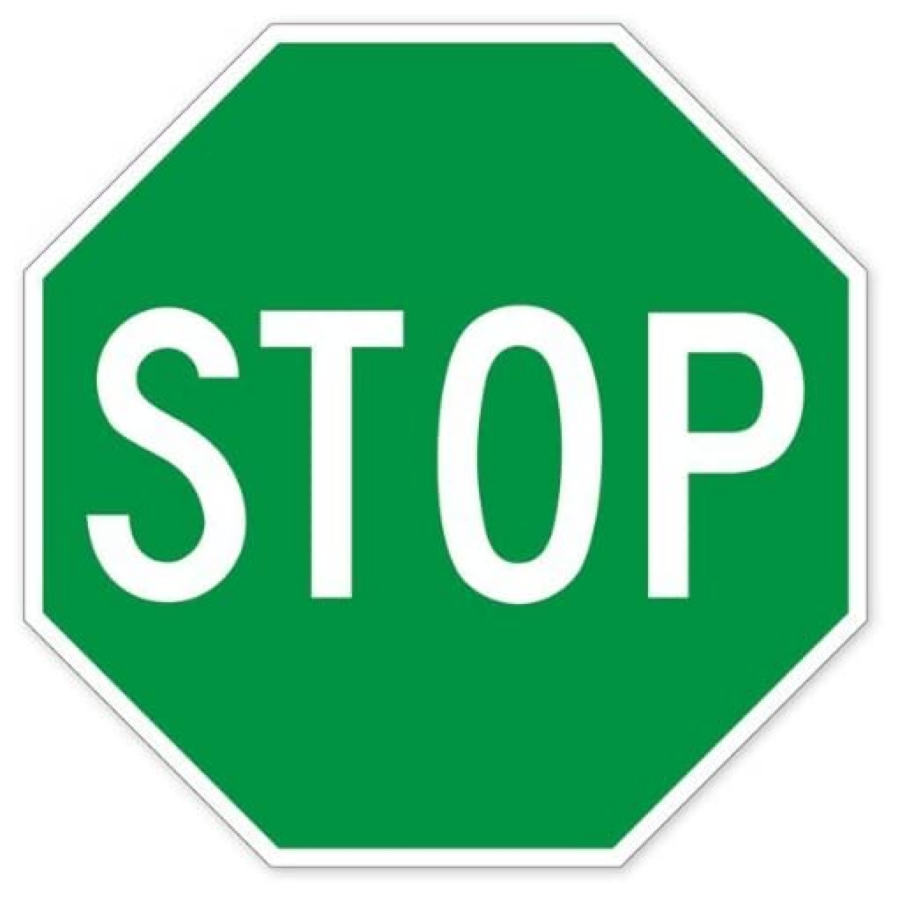

In [136]:
show_image('stop_sign.jpg')

In [138]:
pred = predict_proba(base_model, 'stop_sign.jpg')
pred

array([0.18251735, 0.18234906, 0.21355222, 0.42158136], dtype=float32)

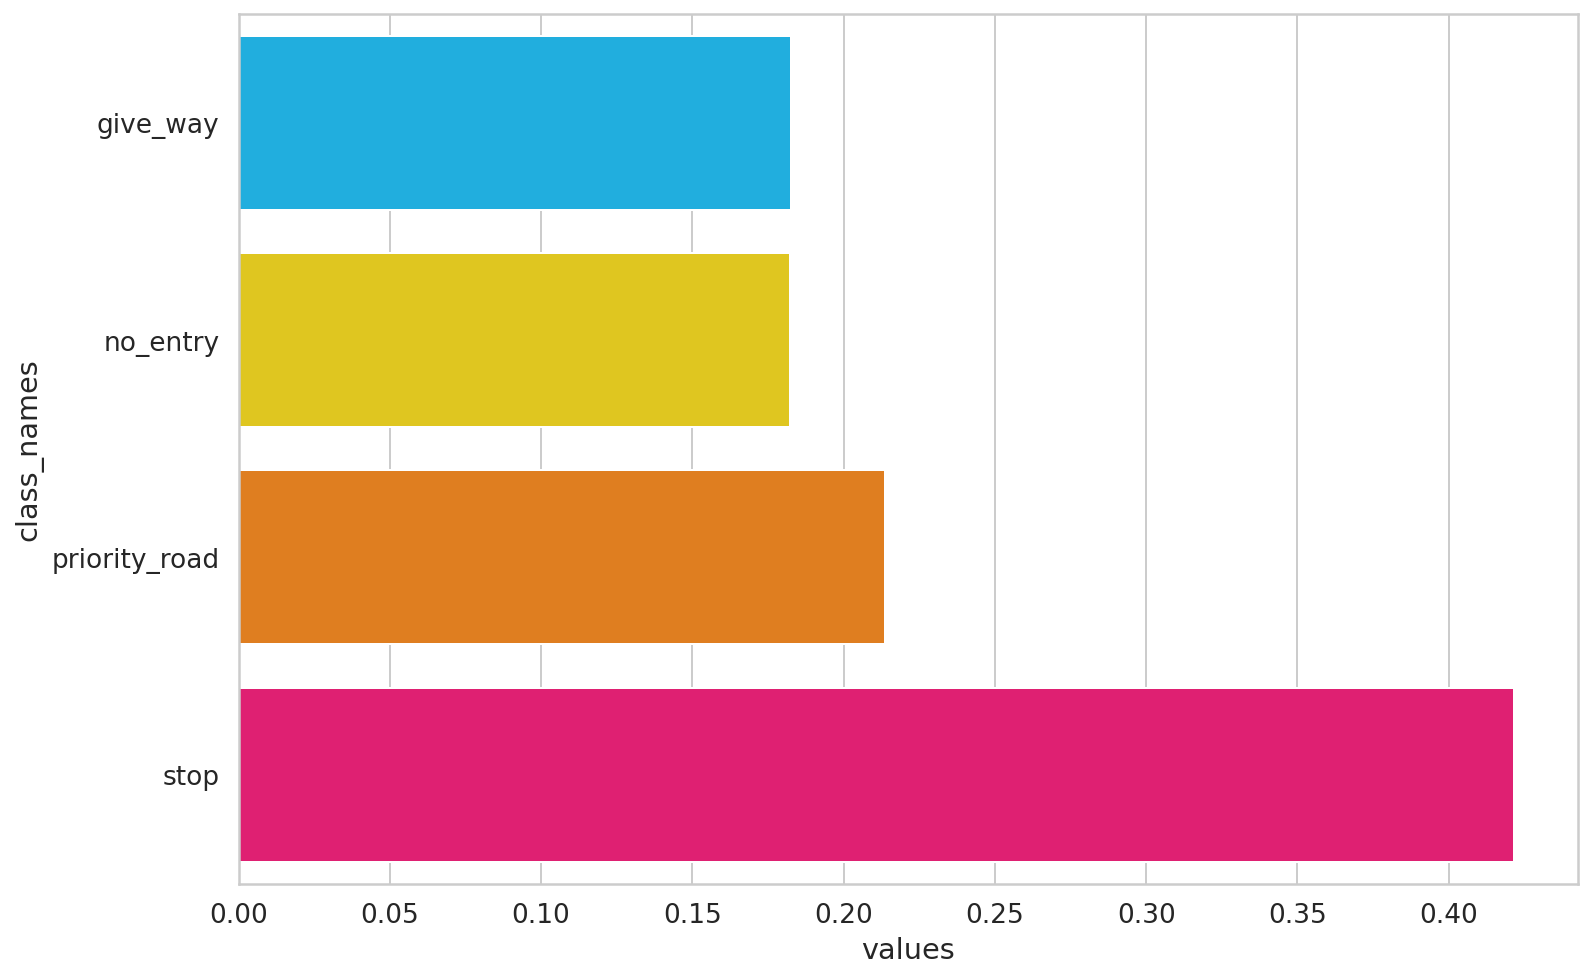

In [139]:
show_prediction_confidence(pred, class_names)
# Yesil Stop Sign Olmasina Ragmen Iyi Tahmin

## Trying Out a Sign Not in the Dataset

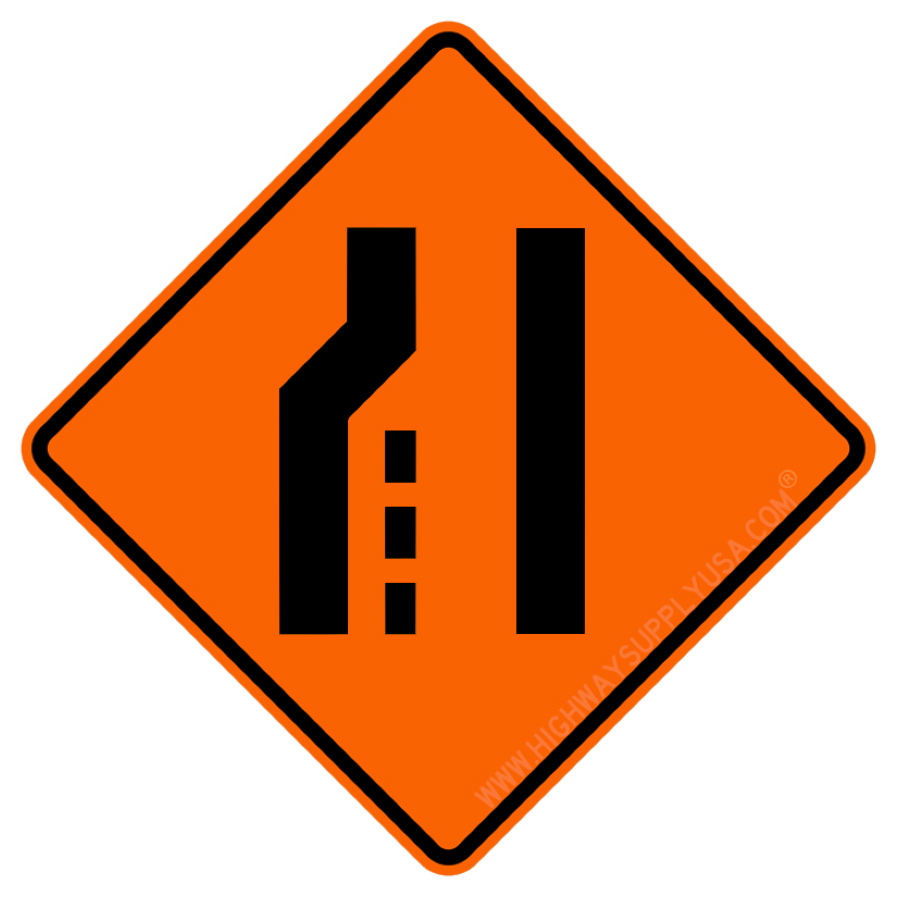

In [140]:
show_image('new_traffic_sign.jpg')

In [141]:
pred = predict_proba(base_model, 'stop_sign.jpg')
pred

array([0.18251735, 0.18234906, 0.21355222, 0.42158136], dtype=float32)

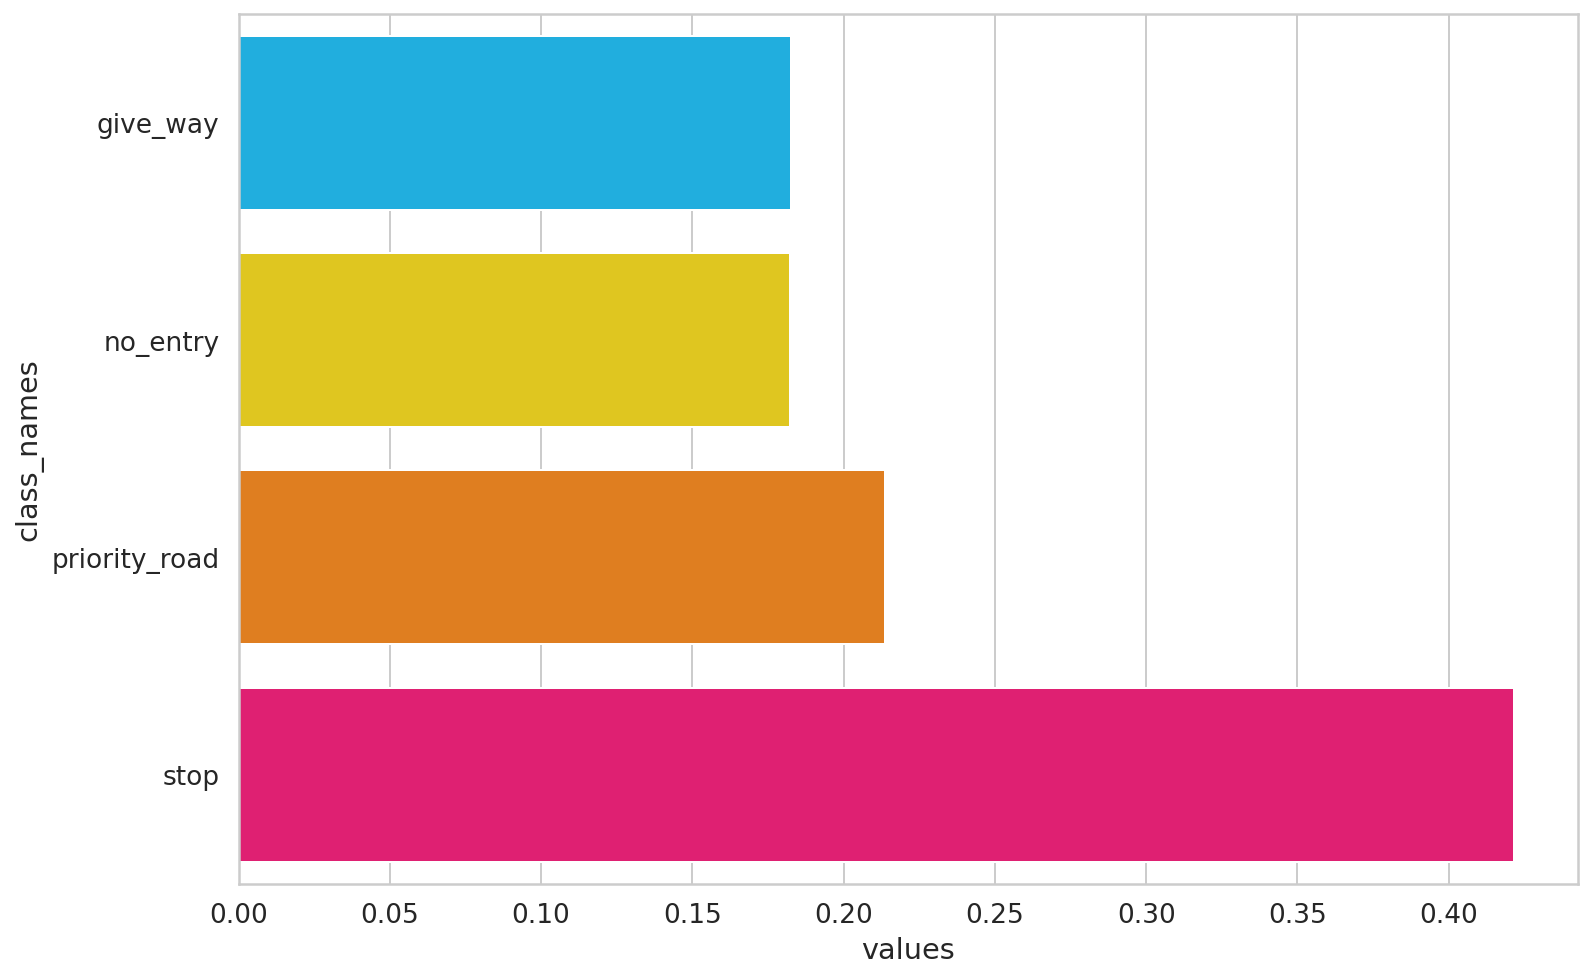

In [142]:
show_prediction_confidence(pred, class_names)

## Adding Class Unknown

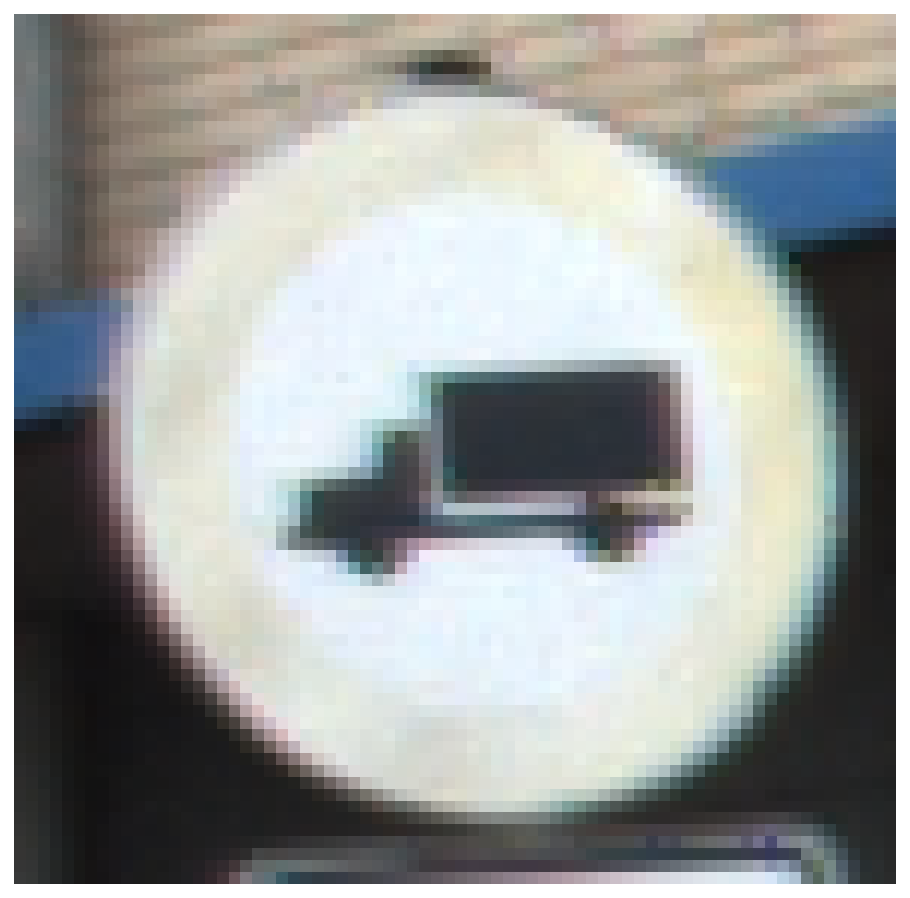

In [171]:
no_truck_index = 16
no_truck_path = glob(f'{train_folders[no_truck_index]}/*ppm')[1]
show_image(no_truck_path)
# Bu class'i training set'e dail etmeyecegiz ve daha sonra bunu test edecegiz

In [148]:
pred = predict_proba(base_model, glob(f'{train_folders[no_truck_index]}/*.ppm')[1])
pred

array([0.17831843, 0.18256219, 0.45448944, 0.18462992], dtype=float32)

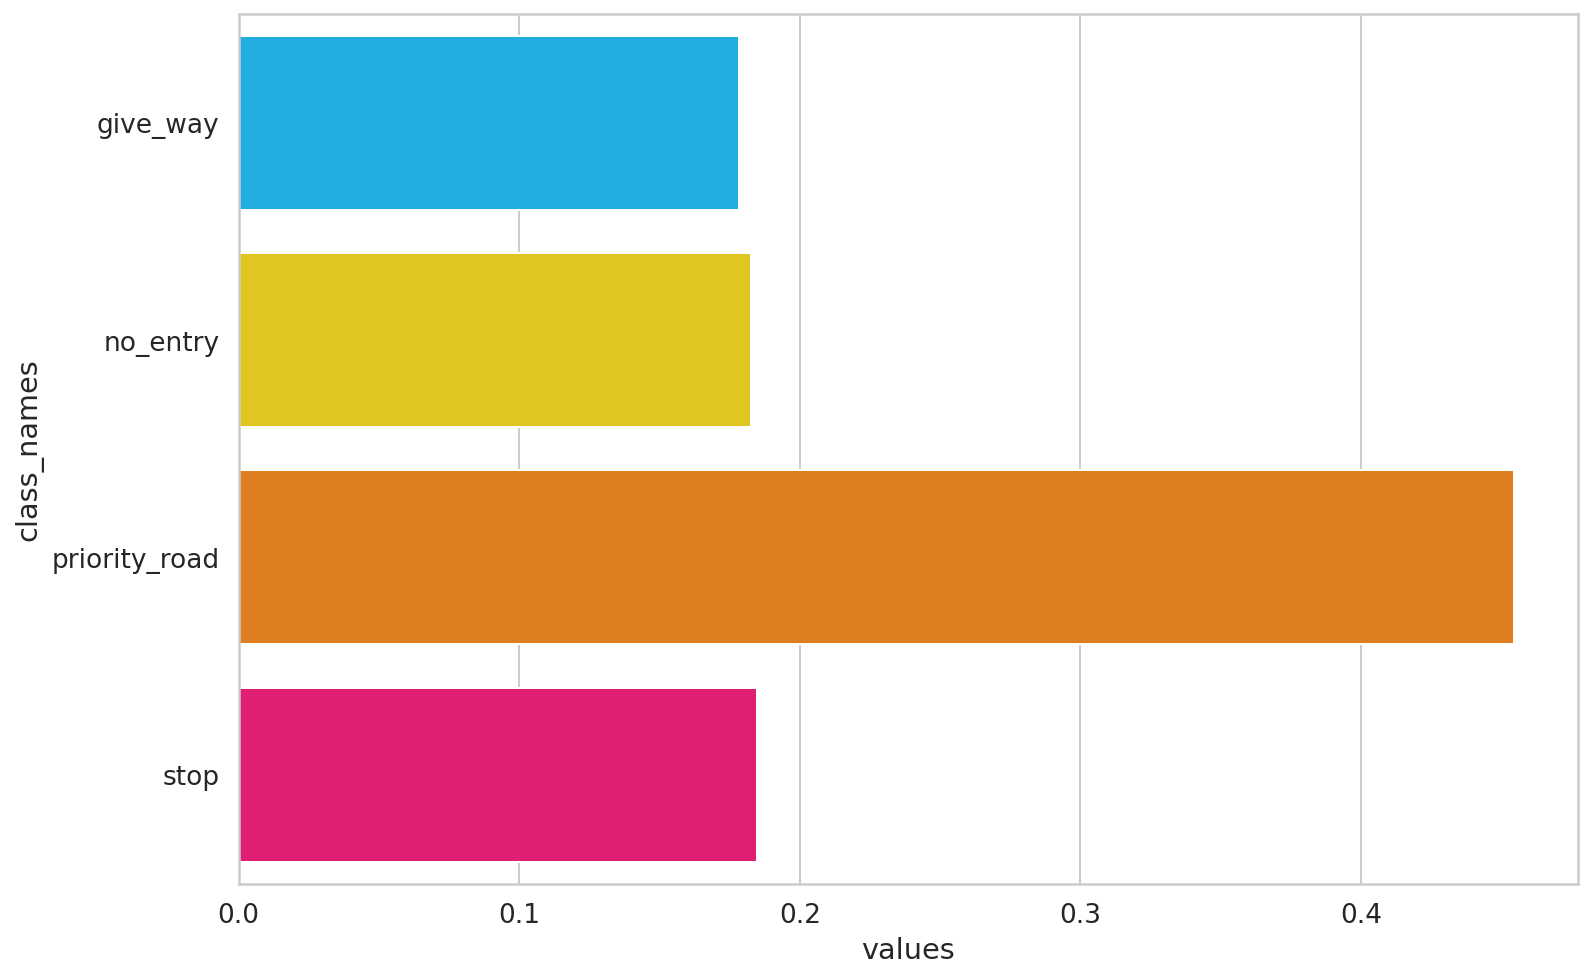

In [149]:
show_prediction_confidence(pred, class_names)

In [0]:
unknown_indices = [i for i, f in enumerate(train_folders) if i not in class_indices and i != no_truck_index]

In [151]:
len(unknown_indices)

38

In [0]:
os.makedirs(f'data/train/unknown', exist_ok=True)
os.makedirs(f'data/valid/unknown', exist_ok=True)
os.makedirs(f'data/test/unknown', exist_ok=True)

In [0]:
for ui in unknown_indices:
    image_paths = np.array(glob(f'{train_folders[ui]}/*.ppm'))
    image_paths = np.random.choice(image_paths, 50)

    train, valid, test = np.split(
        image_paths,
        indices_or_sections = [int(0.8 * len(image_paths)), int(0.9 * len(image_paths))]
    )

    for ip in train:
        shutil.copy(ip, f'data/train/unknown')
    for ip in valid:
        shutil.copy(ip, f'data/valid/unknown')
    for ip in test:
      shutil.copy(ip, f'data/test/unknown')

In [0]:
data_dir= 'data/'
chose_datasets = {
    x: ImageFolder(os.path.join(data_dir, x), transform=chose_transforms[x])
    for x in ['train', 'valid', 'test']
}

In [0]:
dataloaders = {x:DataLoader(dataset = chose_datasets[x], 
                            batch_size=16,
                            shuffle=True,
                            num_workers=4)
                for x in ['train', 'valid', 'test']}

In [161]:
dataset_sizes = {x:len(chose_datasets[x]) for x in ['train', 'valid', 'test']}
dataset_sizes

{'test': 1022, 'train': 7577, 'valid': 1017}

In [162]:
class_names = chose_datasets['train'].classes
class_names

['give_way', 'no_entry', 'priority_road', 'stop', 'unknown']

In [164]:
%%time
enhenced_model = create_model(len(class_names))
enhanced_model, history = train_model(enhenced_model, dataloaders, dataset_sizes, device)

Epoch 1/3
---------------------------------
[INFO] Train Loss 1.1641957123571307 accuracy 0.7673221591658969
[INFO] Validation Loss 1.0656253369525075 accuracy 0.8338249754178958
Epoch 2/3
---------------------------------
[INFO] Train Loss 1.0198141506201104 accuracy 0.8921736835159034
[INFO] Validation Loss 0.9333057040348649 accuracy 0.984267453294002
Epoch 3/3
---------------------------------
[INFO] Train Loss 0.9638538676223675 accuracy 0.9535436188465092
[INFO] Validation Loss 0.9096230547875166 accuracy 1.0
[INFO] Best Val Acc : 0
CPU times: user 1min 10s, sys: 19.9 s, total: 1min 30s
Wall time: 1min 38s


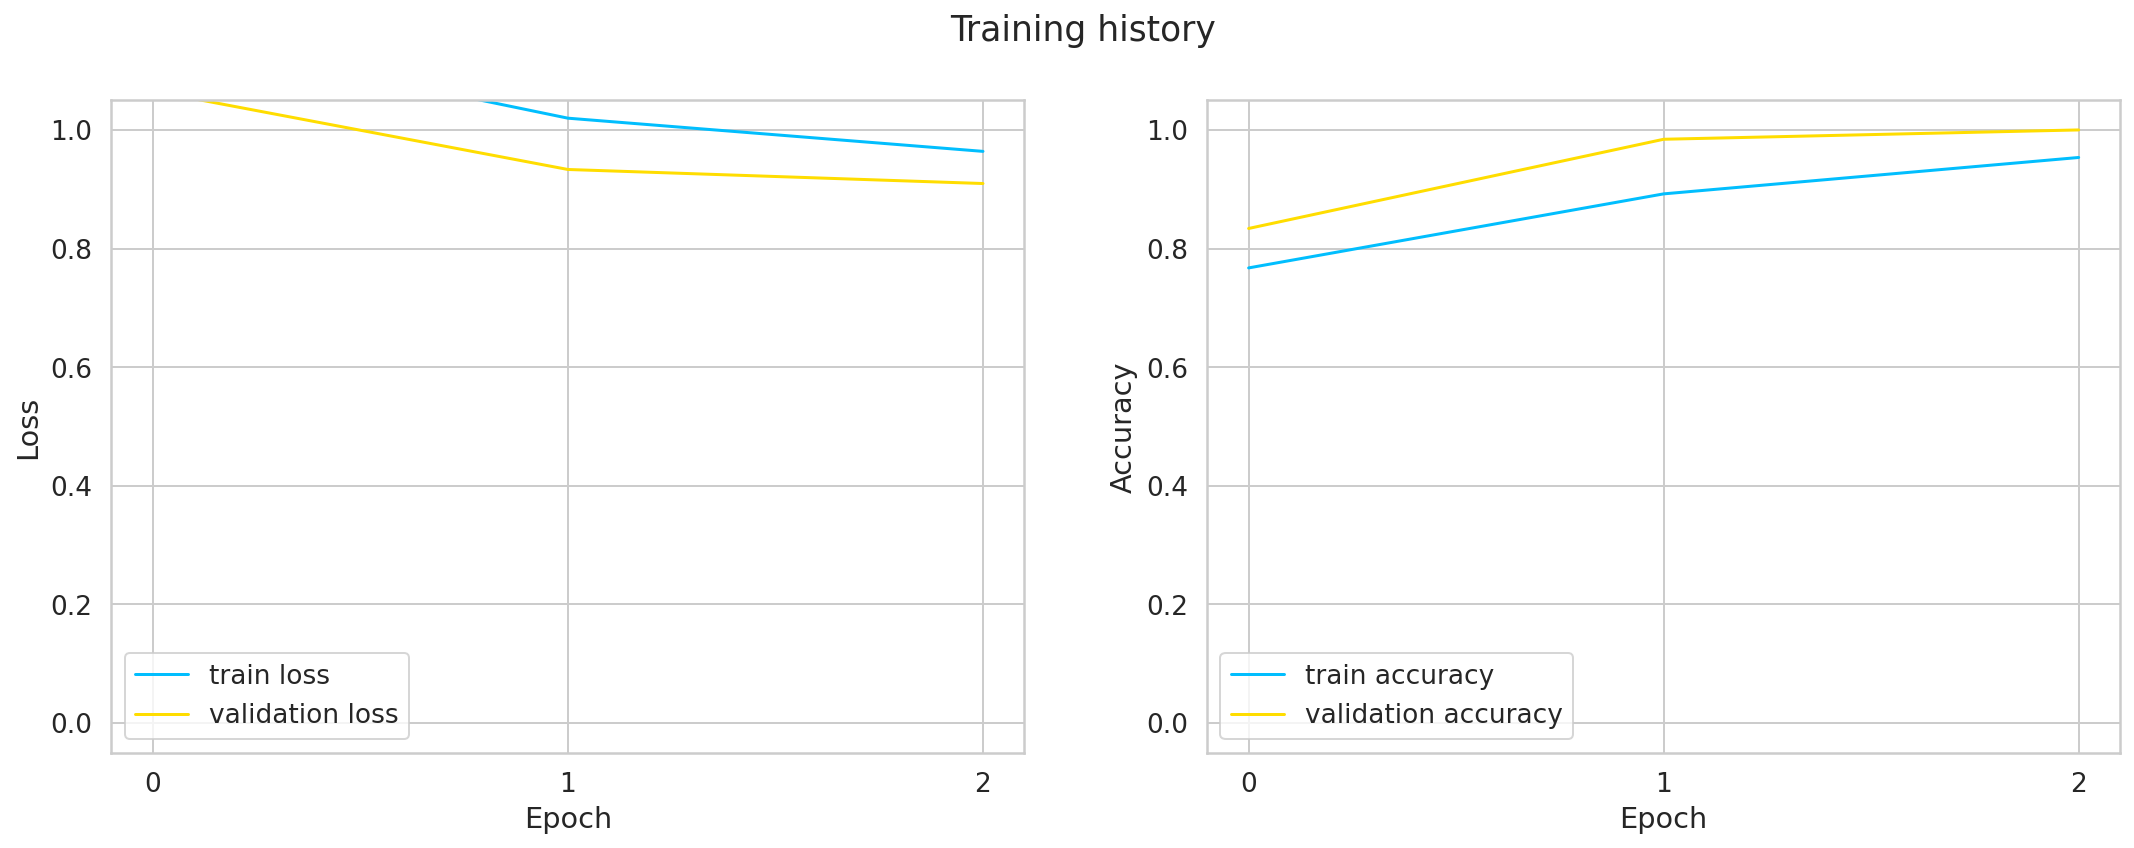

In [166]:
plot_training_history(history)

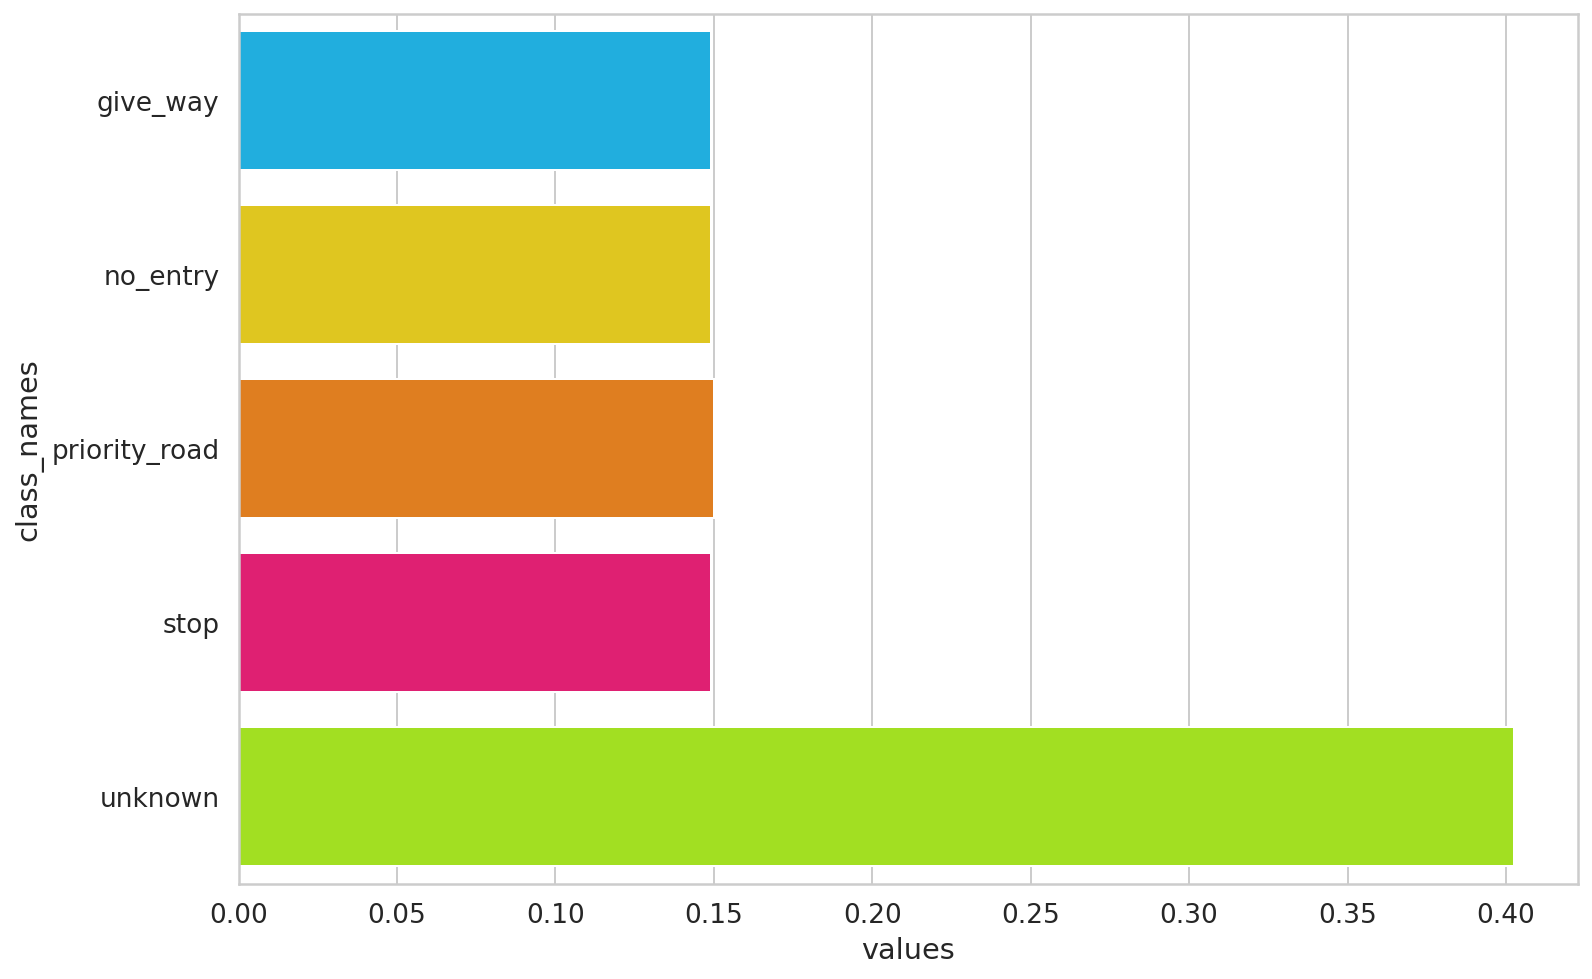

In [177]:
no_truck_path = glob(f'{train_folders[no_truck_index]}/*ppm')[1]
pred = predict_proba(enhenced_model, no_truck_path)
show_prediction_confidence(pred, class_names)

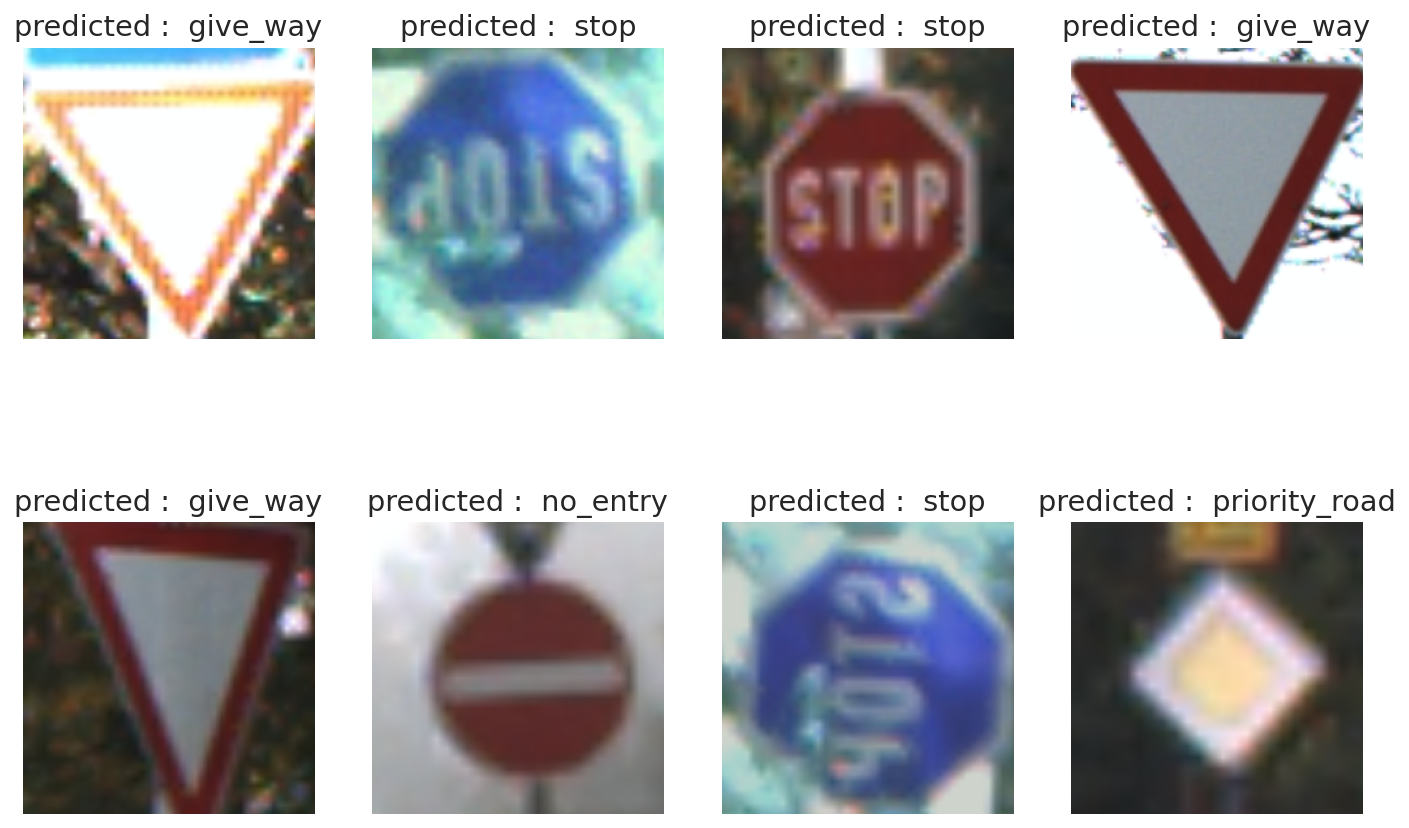

In [178]:
show_predictions(enhenced_model, class_names, n_images=8)

In [0]:
y_pred, y_test = get_predictions(enhenced_model, dataloaders['test'])

In [182]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

     give_way       1.00      1.00      1.00       216
     no_entry       1.00      1.00      1.00       211
priority_road       1.00      1.00      1.00       210
         stop       1.00      1.00      1.00       213
      unknown       1.00      0.99      1.00       172

     accuracy                           1.00      1022
    macro avg       1.00      1.00      1.00      1022
 weighted avg       1.00      1.00      1.00      1022



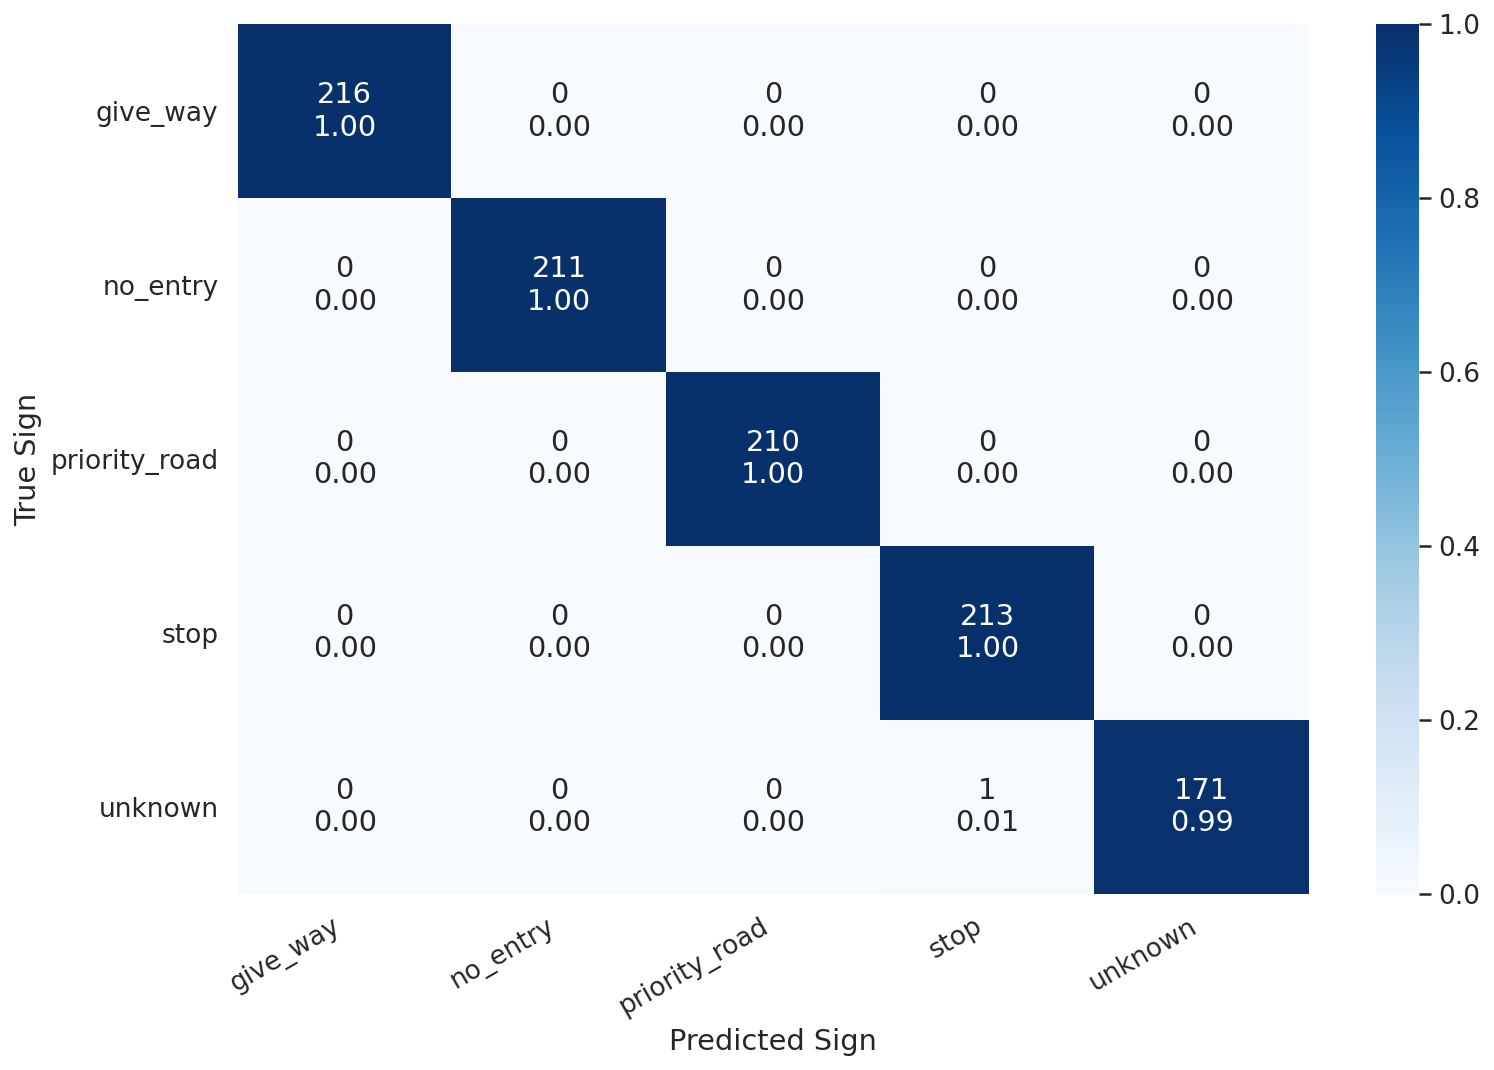

In [183]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)
